In [1]:
cd ..

/home/cms-jovyan/b_lepton_met/analysis


In [2]:
import json
import pickle
import numpy as np
import awkward as ak
import hist as hist2
from typing import List
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection
from corrections import add_pileup_weight
from btag import btagWPs, BTagCorrector
from utils import normalize

In [3]:
class BackgroundEstimatorProcessor(processor.ProcessorABC):
    def __init__(
        self, 
        year: str = "2017", 
        yearmod: str = "",
        channels: List[str] = ["ele", "mu"],
    ):
        self._year = year
        self._yearmod = yearmod
        self._channels = channels
        self.common_weights = ["genweight", "L1Prefiring", "pileup"]
        
        # open triggers
        with open("data/triggers.json", "r") as f:
            self._triggers = json.load(f)[self._year]
            
        # open btagDeepFlavB
        with open("data/btagDeepFlavB.json", "r") as f:
            self._btagDeepFlavB = json.load(f)[self._year]
            
        # open lumi masks
        with open('data/lumi_masks.pkl', 'rb') as handle:
            self._lumi_mask = pickle.load(handle)
            
        # open met filters
        # https://twiki.cern.ch/twiki/bin/view/CMS/MissingETOptionalFiltersRun2
        with open('data/metfilters.json', 'rb') as handle:
            self._metfilters = json.load(handle)[self._year]
            
        # output histograms
        self.make_output = lambda: {
            'sumw' : 0.,
            "bjet_kin": hist2.Hist(
                hist2.axis.StrCategory([], name='weigth', growth=True),
                hist2.axis.StrCategory([], name='region', growth=True),
                hist2.axis.Regular(50, 30, 1000, name="bjet_pt", label=r"b-jet $p_T$ [GeV]"),
                hist2.axis.Regular(20, -5, 5, name="bjet_eta", label=r"b-jet $\eta$"),
                hist2.storage.Weight(),
            ),
            "met_kin": hist2.Hist(
                hist2.axis.StrCategory([], name='weigth', growth=True),
                hist2.axis.StrCategory([], name='region', growth=True),
                hist2.axis.Regular(50, 30, 1000, name="met_pt", label=r"$p_T^{miss}$ [GeV]"),
                hist2.storage.Weight(),
            )
        }
    
    def add_selection(
        self, 
        name: str, 
        sel: np.ndarray, 
        channel: List[str] = None
    ):
        """
        Adds selection to PackedSelection object and the cutflow dictionary
        https://github.com/cmantill/boostedhiggs/blob/main/boostedhiggs/hwwprocessor.py
        """
        channels = channel if channel else self._channels
        for ch in channels:
            self.selections[ch].add(name, sel)
            selection_ch = self.selections[ch].all(*self.selections[ch].names)
            if self.isMC:
                weight = self.weights.partial_weight(self.weights_per_ch[ch] + self.common_weights)
                self.cutflows[ch][name] = float(weight[selection_ch].sum())
            else:
                self.cutflows[ch][name] = np.sum(selection_ch)
        
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events: ak.Array):
        dataset = events.metadata["dataset"]
        nevents = len(events)
        output = self.make_output()
        
        self.isMC = hasattr(events, "genWeight")
        self.weights = Weights(nevents, storeIndividual=True)
        self.weights_per_ch = {}
        self.selections = {}
        self.cutflows = {}
        for ch in self._channels:
            self.weights_per_ch[ch] = []
            self.selections[ch] = PackedSelection()
            self.cutflows[ch] = {}

        output['sumw'] = ak.sum(events.genWeight) if self.isMC else 0
        
        # lumi 
        if not self.isMC:
            self._lumi = self._lumi_mask[self._year](events.run, events.luminosityBlock)
        else:
            self._lumi = np.ones(len(events), dtype='bool')

        # MET filters
        metfilters = np.ones(nevents, dtype="bool")
        metfilterkey = "mc" if self.isMC else "data"
        for mf in self._metfilters[metfilterkey]:
            if mf in events.Flag.fields:
                metfilters = metfilters & events.Flag[mf]
                
        # triggers
        trigger = {}
        for ch in self._channels:
            trigger[ch] = np.zeros(nevents, dtype="bool")
            for t in self._triggers[ch]:
                if t in events.HLT.fields:
                    trigger[ch] = trigger[ch] | events.HLT[t]
            
        # b-tagging corrector
        self._btagWPs = btagWPs["deepJet"][self._year + self._yearmod]
        self._btagSF = BTagCorrector("M", "deepJet", self._year, self._yearmod)
        
        # electrons 
        good_electrons = (
            (events.Electron.pt > 0)
            & (np.abs(events.Electron.eta) < 2.4)
            & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
            & (events.Electron.mvaFall17V2noIso_WP90)
        )
        n_good_electrons = ak.sum(good_electrons, axis=1)
        
        
        # muons
        # mediumId OR tightId?
        # DO WE NEED LOOSE MUONS? 
        good_muons = (
            (events.Muon.pt > 30)
            & (np.abs(events.Muon.eta) < 2.4)
            & events.Muon.mediumId
        )
        n_good_muons = ak.sum(good_muons, axis=1)
        
        # get candidate lepton
        goodleptons = ak.concatenate(
            [events.Muon[good_muons], events.Electron[good_electrons]], axis=1
        )  
        goodleptons = goodleptons[ak.argsort(goodleptons.pt, ascending=False)]  
        candidatelep = ak.firsts(goodleptons)
        
        
        # b-jets
        # IS btagDeepFlavB YEAR AND CHANNEL DEPENDENT?
        good_bjets = (
            (ak.firsts(events.Jet.pt) > 30)
            & (events.Jet.jetId == 6)
            & (events.Jet.puId == 7)
            & (events.Jet.btagDeepFlavB > self._btagDeepFlavB)
        )
        n_good_bjets = ak.sum(good_bjets, axis=1)
        
        # MET
        met = events.MET#[events.MET.pt > 50]
        
        # weights
        weigths = {}
        if self.isMC:
            # gen weigth
            self.weights.add("genweight", events.genWeight)
            
             # L1prefiring weigth
            if self._year in ("2016", "2017"):
                self.weights.add(
                    "L1Prefiring", events.L1PreFiringWeight.Nom, events.L1PreFiringWeight.Up, events.L1PreFiringWeight.Dn
                )
                
            # pileup weigth
            add_pileup_weight(self.weights, self._year, self._yearmod, nPU=ak.to_numpy(events.Pileup.nPU))
            
            # b-tagging weigths
            self._btagSF.addBtagWeight(events.Jet[good_bjets], self.weights)
                    
        # selections
        self.add_selection("all", np.ones(nevents, dtype="bool"))
        for ch in self._channels:
            self.add_selection("trigger", trigger[ch], [ch])
        self.add_selection(
            name="one_lepton",
            sel=(
                (n_good_muons == 1)
                & (n_good_electrons == 0)
            ),
            channel=["mu"],
        )
        self.add_selection(
            name="one_lepton",
            sel=(
                (n_good_muons == 0)
                & (n_good_electrons == 1)
            ),
            channel=["ele"],
        )
        self.add_selection("two_bjets", n_good_bjets >= 2)
        self.add_selection("metfilters", metfilters)
        
        regions = {
            "ele_control": ["trigger", "metfilters", "one_lepton", "two_bjets"],
            "mu_control": ["trigger", "metfilters", "one_lepton", "two_bjets"]
        }

        def fill(region: str):
            selections = regions[region]
            if "ele" in region:
                cut = self.selections["ele"].all(*selections)
            elif "mu" in region:
                cut = self.selections["mu"].all(*selections)
            
            for weigth in ["genweight", "L1Prefiring", "pileup", "btagSF", "all"]:
                w = self.weights.partial_weight(include=[weigth]) if weigth != "all" else self.weights.weight()
                output["bjet_kin"].fill(
                    region=region,
                    weigth=weigth,
                    bjet_pt=normalize(ak.firsts(events.Jet[good_bjets].pt), cut),
                    bjet_eta=normalize(ak.firsts(events.Jet[good_bjets].eta), cut),
                    weight=w[cut],
                )
                output["met_kin"].fill(
                    region=region,
                    weigth=weigth,
                    met_pt=normalize(met.pt, cut),
                    weight=w[cut],
                )
            
        for region in regions:
            fill(region)
        
        return {dataset: output}
        
    def postprocess(self, accumulator):
        return accumulator

In [4]:
fileset = {
    "TTTo2L2Nu": ["root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/768FBF80-3166-BC46-8A56-90CF69AFB99C.root"],
}

In [5]:
out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=BackgroundEstimatorProcessor(),
    executor=processor.IterativeExecutor,
    executor_args={
        "schema": processor.NanoAODSchema,
    },
)

Output()

Output()

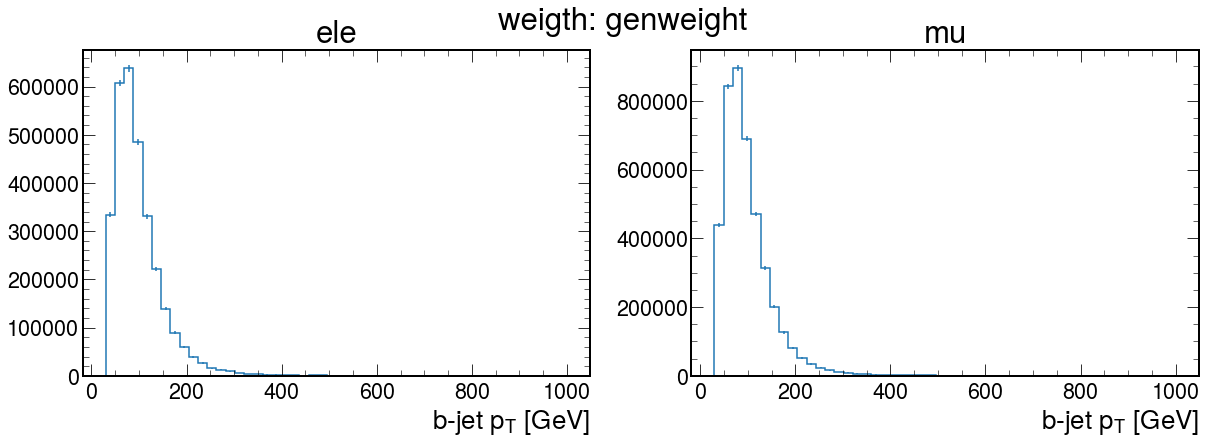

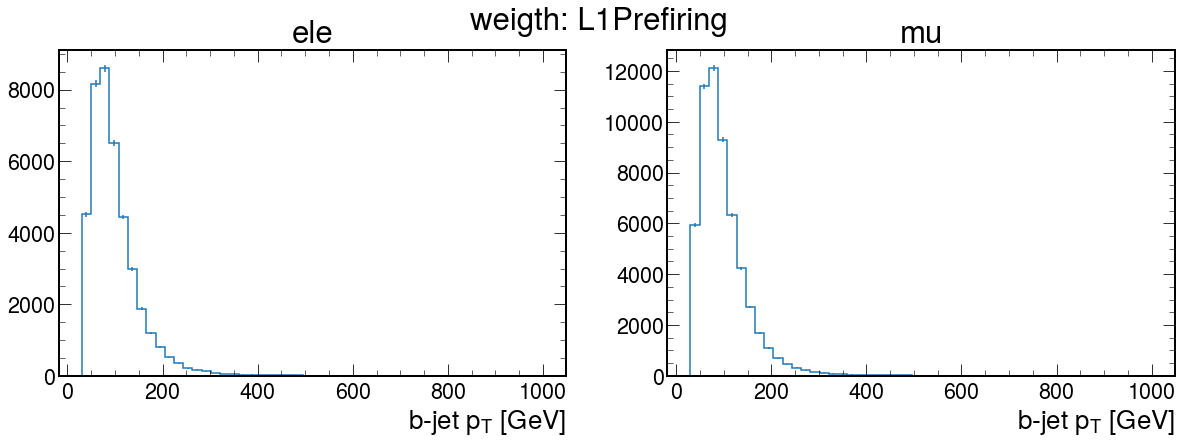

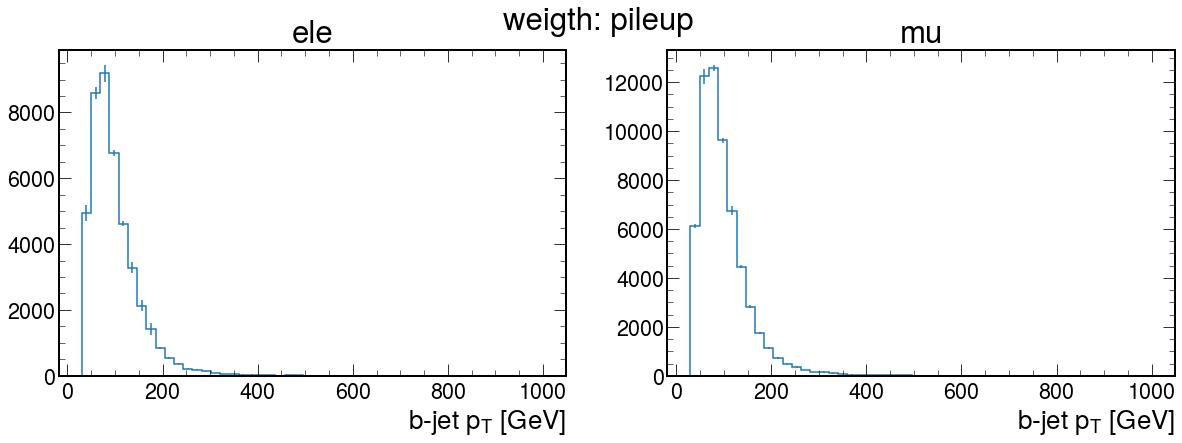

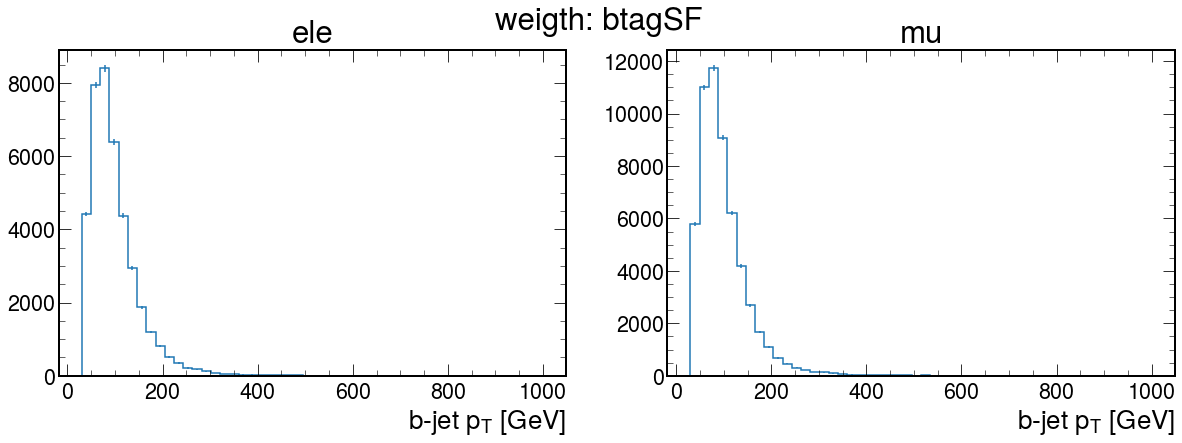

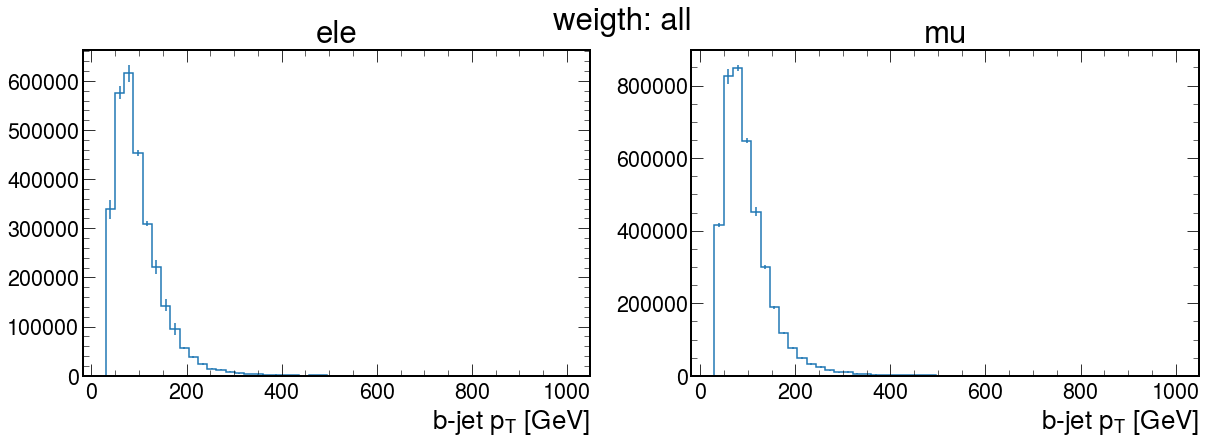

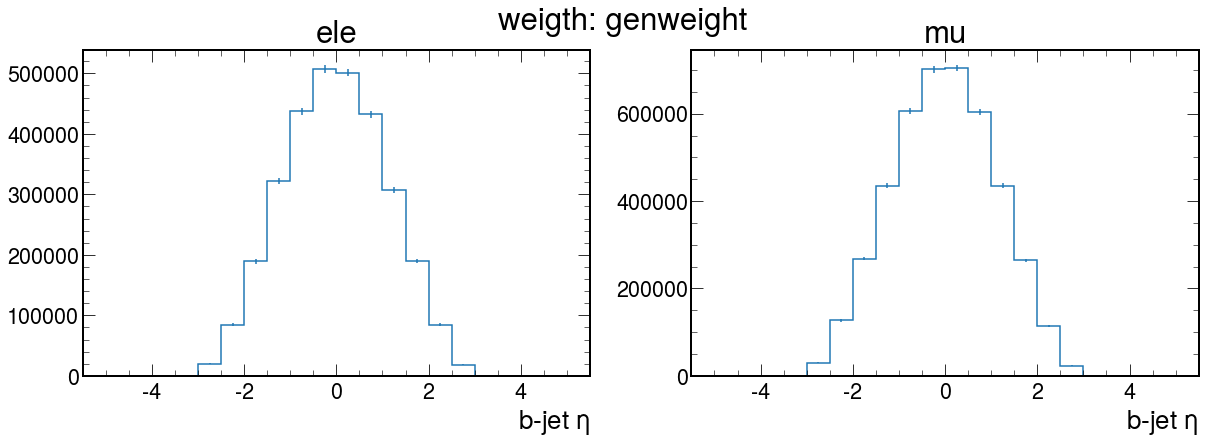

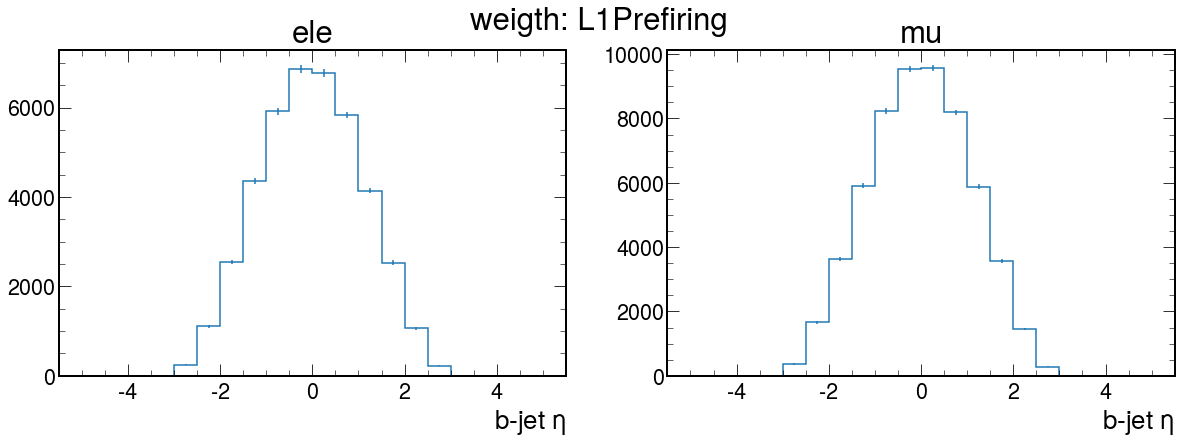

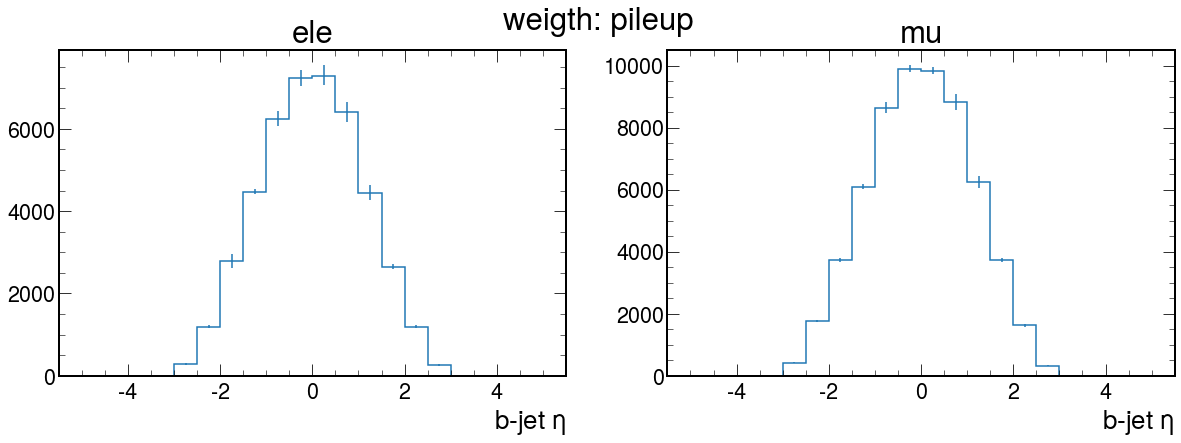

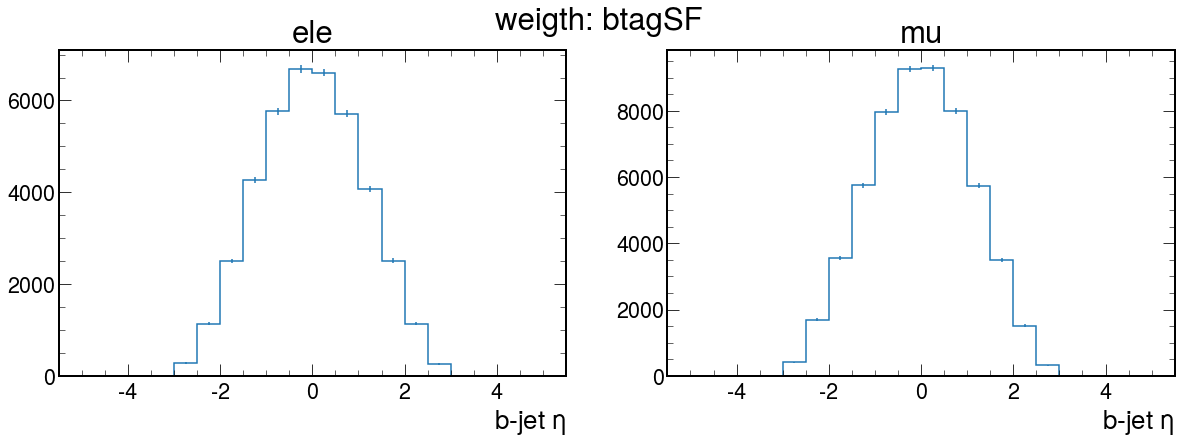

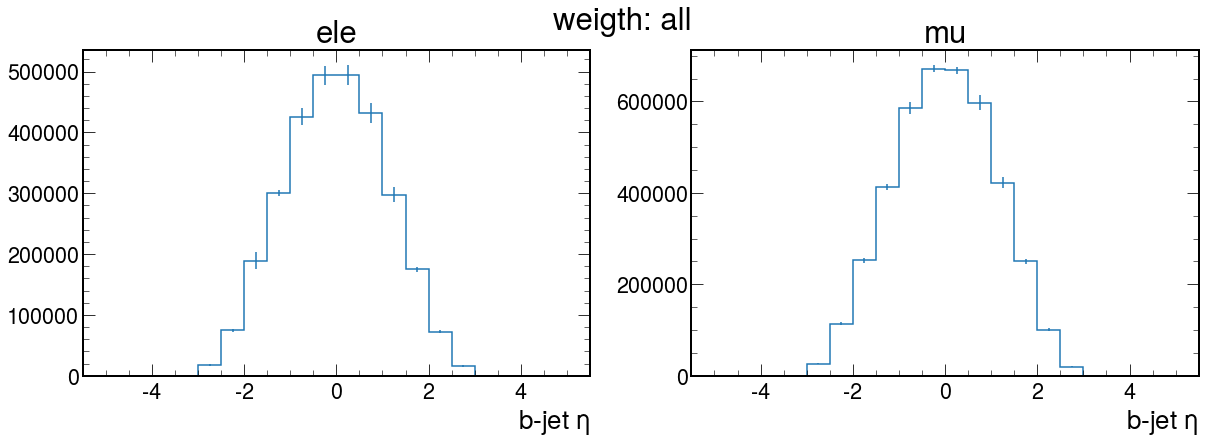

In [6]:
import mplhep as hep
import matplotlib.pyplot as plt
hep.style.use(hep.style.CMS)

for kin in ["pt", "eta"]:
    for weigth in ["genweight", "L1Prefiring", "pileup", "btagSF", "all"]:
        fig, ax = plt.subplots(1, 2, figsize=(20, 6))
        fig.suptitle(f"weigth: {weigth}")
        ax[0].set(title="ele")
        ax[1].set(title="mu")
        hep.histplot(out['TTTo2L2Nu']["bjet_kin"][{"region":"ele_control", "weigth":weigth}].project(f"bjet_{kin}"), ax=ax[0])
        hep.histplot(out['TTTo2L2Nu']["bjet_kin"][{"region":"mu_control", "weigth":weigth}].project(f"bjet_{kin}"), ax=ax[1])

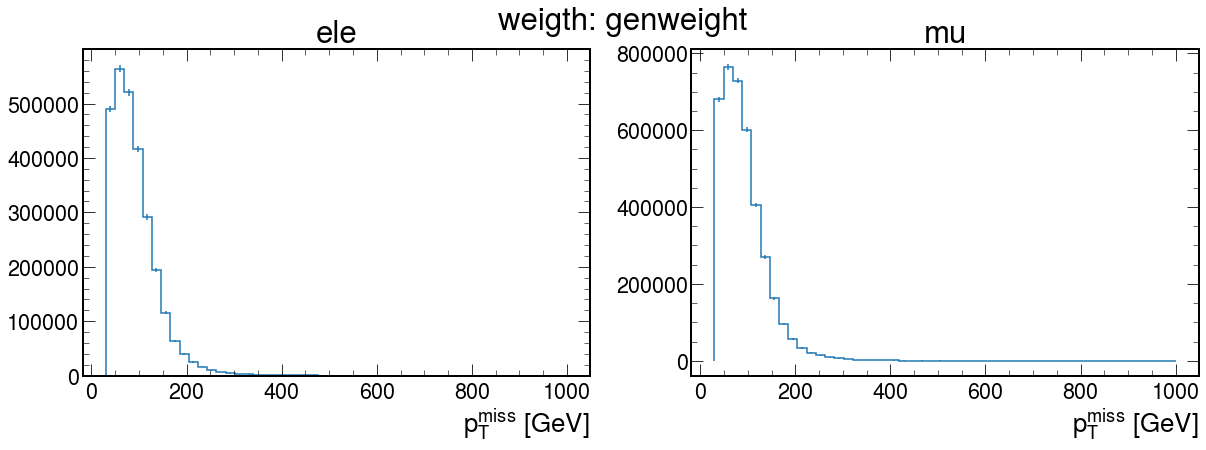

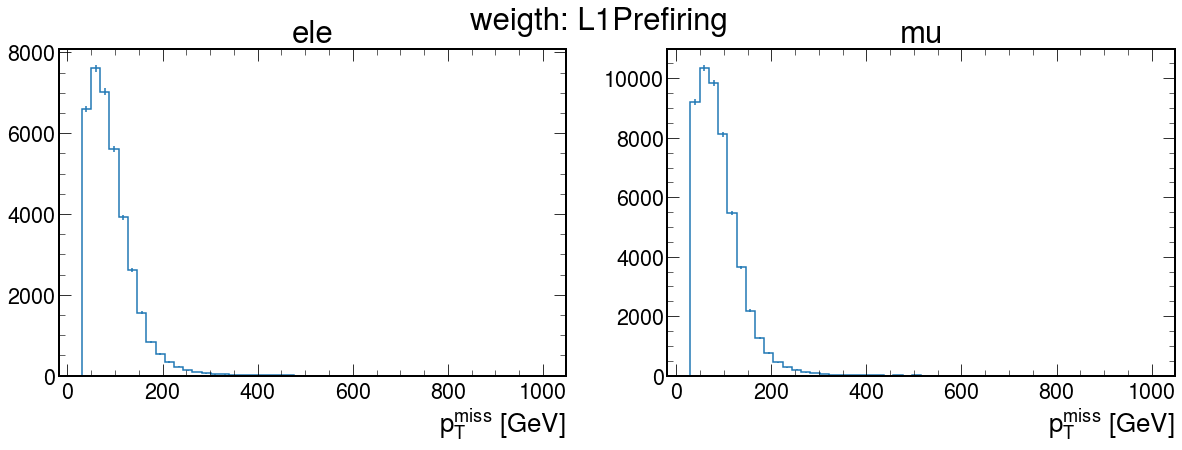

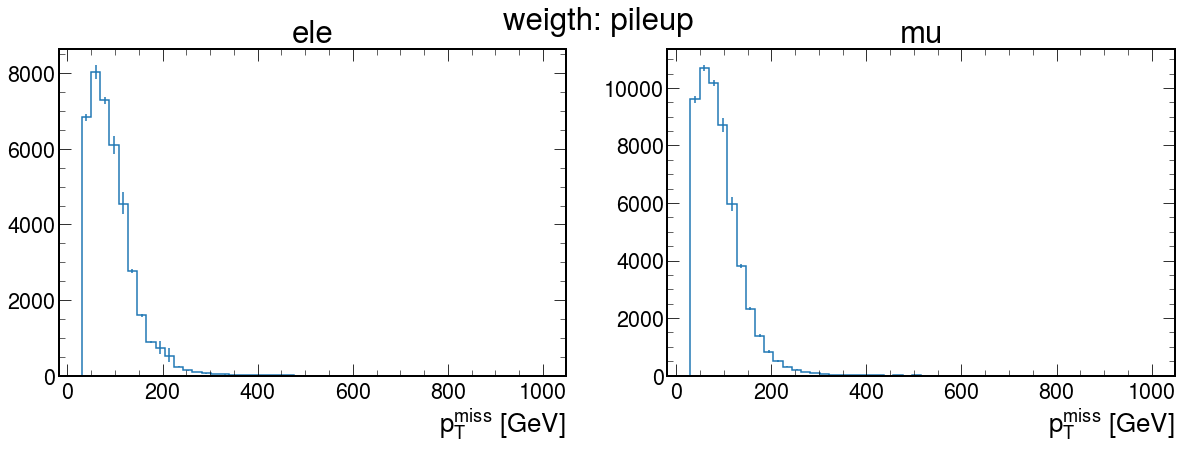

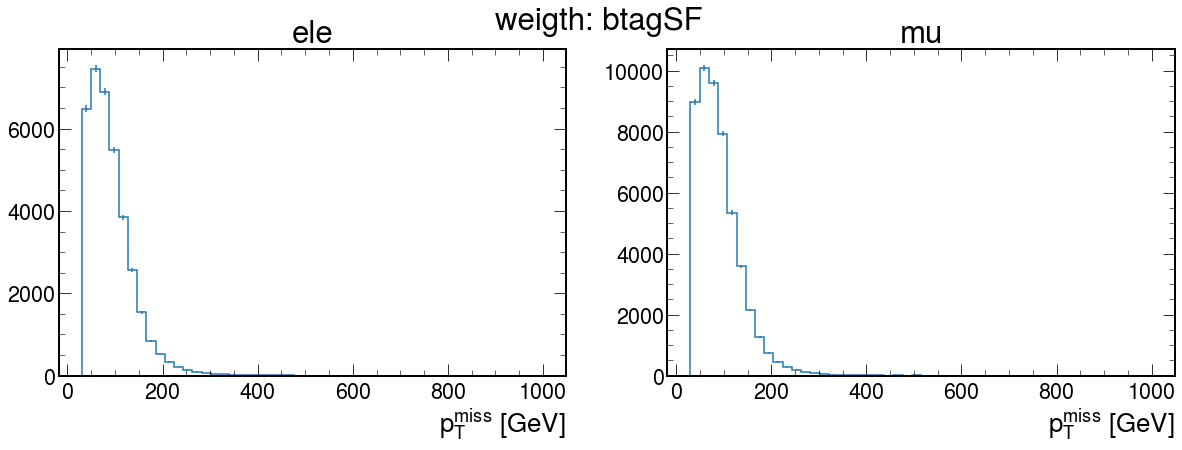

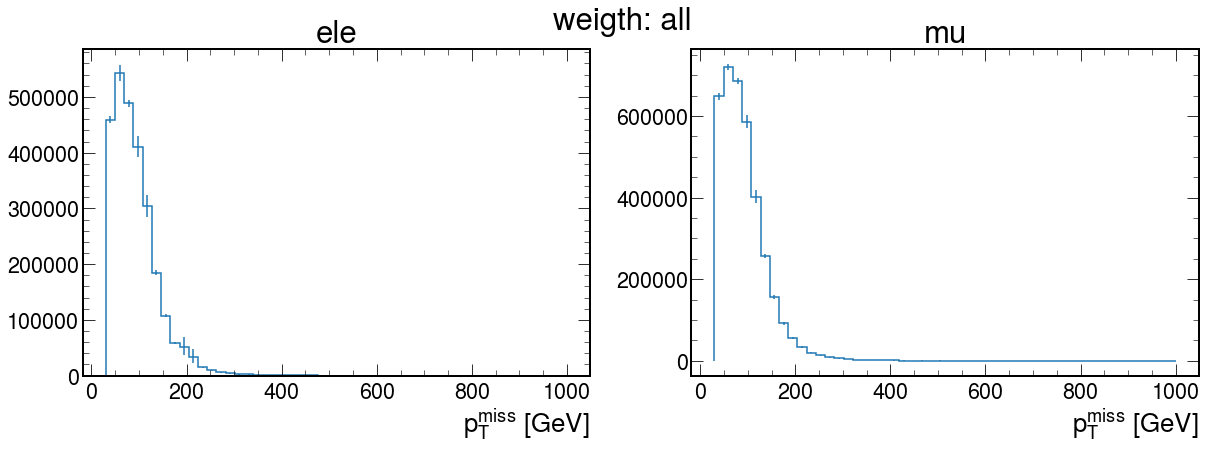

In [7]:
for weigth in ["genweight", "L1Prefiring", "pileup", "btagSF", "all"]:
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle(f"weigth: {weigth}")
    ax[0].set(title="ele")
    ax[1].set(title="mu")
    hep.histplot(out['TTTo2L2Nu']["met_kin"][{"region":"ele_control", "weigth":weigth}].project(f"met_pt"), ax=ax[0])
    hep.histplot(out['TTTo2L2Nu']["met_kin"][{"region":"mu_control", "weigth":weigth}].project(f"met_pt"), ax=ax[1])